In [ ]:
%%capture
import torch

# 1. Pytorch sürümüne uygun hazır binary (wheel) adresini tanımla
# Bu komut derlemeyi atlar ve direkt dosyayı indirir.
!pip install --no-deps "xformers<0.0.27" --index-url https://download.pytorch.org/whl/cu121

# 2. Şimdi Unsloth ve diğerlerini kur (Xformers zaten kurulu olduğu için atlayacak)
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps trl peft accelerate bitsandbytes
!pip install psutil
print("Kurulum bitti! Derleme yapılmadı.")

In [ ]:
from unsloth import FastLanguageModel
import torch
import psutil
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

print("Model başarıyla yüklendi!")

==((====))==  Unsloth 2025.12.9: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Model başarıyla yüklendi!


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)
print("LoRA adaptörleri eklendi!")

LoRA adaptörleri eklendi!


In [ ]:
import json
import random
from datasets import load_dataset, concatenate_datasets

print("🚀 Starting MAXIMUM English Data Preparation...")

# ==========================================
# 1. OCR NOISE INJECTION (AUGMENTATION)
# ==========================================
def inject_ocr_noise(text, probability=0.1):
    noise_map = {
        'S': '5', '5': 'S', 'I': '1', '1': 'I', 'l': '1',
        'O': '0', '0': 'O', 'B': '8', '8': 'B', 'Z': '2', '2': 'Z',
        '.': ',', ' ': '  '
    }
    chars = list(text)
    for i, char in enumerate(chars):
        if random.random() < probability:
            if char in noise_map:
                chars[i] = noise_map[char]
            elif random.random() < 0.1:
                chars[i] = random.choice(['.', '-', '*', '_'])
    return "".join(chars)

# ==========================================
# 2. LOAD & PROCESS ALL SPLITS (Train + Val + Test)
# ==========================================
processed_data = []

try:
    print("🌍 Loading CORD Dataset (ALL SPLITS)...")
    # BURASI DEĞİŞTİ: Train, Validation ve Test setlerini birleştiriyoruz
    ds_train = load_dataset("naver-clova-ix/cord-v2", split="train")
    ds_val = load_dataset("naver-clova-ix/cord-v2", split="validation")
    ds_test = load_dataset("naver-clova-ix/cord-v2", split="test")

    # Hepsini tek bir pakette topla
    full_dataset = concatenate_datasets([ds_train, ds_val, ds_test])

    print(f"✅ Processing {len(full_dataset)} total CORD receipts...")

    for item in full_dataset:
        try:
            gt_json = json.loads(item.get('ground_truth', '{}'))

            # Text oluştur
            lines = []
            if "valid_line" in gt_json:
                for l in gt_json["valid_line"]:
                    words = l.get("words", [])
                    lines.append(" ".join([w["text"] for w in words]))
            full_text = "\n".join(lines)

            # Değerleri çek
            date_val = "Not Found"
            total_val = "0.00"
            tax_val = "0.00"
            merchant_val = "Unknown"

            if "valid_line" in gt_json:
                for l in gt_json["valid_line"]:
                    cat = l.get("category", "")
                    txt = " ".join([w["text"] for w in l.get("words", [])])
                    if "menu.date" in cat: date_val = txt
                    elif "total.total_price" in cat: total_val = txt
                    elif "total.tax_price" in cat: tax_val = txt
                    elif "store.name" in cat: merchant_val = txt

            if total_val == "0.00": continue

            gt = {
                "merchant": merchant_val,
                "date": date_val,
                "total_price": total_val,
                "tax": tax_val
            }

            # Original
            processed_data.append({"text": full_text, "gt": gt})
            # Augmentation (Gürültülü Kopya)
            processed_data.append({"text": inject_ocr_noise(full_text, 0.15), "gt": gt})

        except: continue

except Exception as e:
    print(f"⚠️ Error: {e}")

print(f"\n📊 NEW TOTAL TRAINING SAMPLES: {len(processed_data)}")

# ==========================================
# 3. SAVE TO JSONL
# ==========================================
final_jsonl = []
prompt_template = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Extract the merchant name, date, total price, and tax amount from the receipt text into a structured JSON format.

### Input:
{text}

### Response:
{response}""" + "<|end_of_text|>"

for item in processed_data:
    response_str = json.dumps(item['gt'], ensure_ascii=False)
    formatted_text = prompt_template.format(text=item['text'], response=response_str)
    final_jsonl.append({"text": formatted_text})

random.shuffle(final_jsonl)

output_filename = "english_receipt_dataset.jsonl"
with open(output_filename, "w", encoding="utf-8") as f:
    for entry in final_jsonl:
        f.write(json.dumps(entry, ensure_ascii=False) + "\n")

print(f"💾 Saved to '{output_filename}'")

🚀 Starting MAXIMUM English Data Preparation...
🌍 Loading CORD Dataset (ALL SPLITS)...
✅ Processing 1000 total CORD receipts...

📊 NEW TOTAL TRAINING SAMPLES: 1944
💾 Saved to 'english_receipt_dataset.jsonl'


In [ ]:
from datasets import load_dataset

# 1. Yeni oluşturduğumuz İngilizce veri setini yüklüyoruz
dataset = load_dataset("json", data_files="english_receipt_dataset.jsonl", split="train")

# 2. EOS Token (Cümlenin bittiğini anlatan işaret) kontrolü
EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    texts = examples["text"]
    outputs = []
    for text in texts:
        # Eğer zaten yoksa sonuna EOS ekle
        if not text.endswith(EOS_TOKEN):
            text += EOS_TOKEN
        outputs.append(text)
    return {"text": outputs}

dataset = dataset.map(formatting_prompts_func, batched=True)

print(f"✅ Eğitim için hazır veri sayısı: {len(dataset)}")
print("🚀 Şimdi bir sonraki hücredeki 'Eğitim Kodunu' çalıştırabilirsin!")

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1944 [00:00<?, ? examples/s]

✅ Eğitim için hazır veri sayısı: 1944
🚀 Şimdi bir sonraki hücredeki 'Eğitim Kodunu' çalıştırabilirsin!


In [ ]:
# ==========================================================
# 1. PSUTIL YAMASI (ZORUNLU)
# ==========================================================
import os
import builtins
try:
    import psutil
except ImportError:
    os.system("pip install psutil")
    import psutil

# Psutil'i sisteme gömüyoruz
builtins.psutil = psutil
print(f"✅ Psutil sisteme gömüldü. RAM: {psutil.virtual_memory().percent}%")

# ==========================================================
# 2. LORA ADAPTÖRLERİNİ GARANTİYE AL (Eksik olma ihtimaline karşı)
# ==========================================================
from unsloth import FastLanguageModel
import torch

# Model değişkeni hafızada olsa bile LoRA'yı tekrar tanımlamak güvenlidir
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)
print("✅ LoRA Adaptörleri aktif edildi (Garanti altına alındı).")

# ==========================================================
# 3. SENİN EĞİTİM KODUN (OPTIMIZE EDİLMİŞ)
# ==========================================================
from trl import SFTTrainer
from transformers import TrainingArguments, EarlyStoppingCallback
from unsloth import is_bfloat16_supported

# Veriyi ayır
dataset_split = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset_split["train"]
eval_dataset = dataset_split["test"]

print(f"Eğitim Verisi: {len(train_dataset)} | Doğrulama Verisi: {len(eval_dataset)}")

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length, # Daha önce tanımladığın değişken
    dataset_num_proc = 2,
    packing = False,

    args = TrainingArguments(
        # --- A100 Performans Ayarları ---
        per_device_train_batch_size = 32,
        per_device_eval_batch_size = 16,
        gradient_accumulation_steps = 1,
        num_train_epochs = 3,

        # --- Öğrenme Stratejisi ---
        learning_rate = 2e-4,
        lr_scheduler_type = "cosine",
        warmup_ratio = 0.1,

        # --- Stabilite & Kalite ---
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        max_grad_norm = 1.0,
        neftune_noise_alpha = 5,

        # --- Değerlendirme ---
        eval_strategy = "steps",
        eval_steps = 50,
        save_strategy = "steps",
        save_steps = 50,
        load_best_model_at_end = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,

        seed = 3407,
        output_dir = "outputs_a100_optimized",
        report_to = "none",
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("🚀 ScanHub Modeli İçin A100 Eğitimi Başlıyor...")
trainer_stats = trainer.train()
print(f"🎉 EĞİTİM TAMAMLANDI! En iyi model yüklendi.")

Unsloth: Already have LoRA adapters! We shall skip this step.


✅ Psutil sisteme gömüldü. RAM: 19.3%
✅ LoRA Adaptörleri aktif edildi (Garanti altına alındı).
Eğitim Verisi: 1749 | Doğrulama Verisi: 195


The model is already on multiple devices. Skipping the move to device specified in `args`.


🚀 ScanHub Modeli İçin A100 Eğitimi Başlıyor...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,749 | Num Epochs = 3 | Total steps = 165
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 24,313,856 of 3,237,063,680 (0.75% trained)


Step,Training Loss,Validation Loss
50,0.706300,0.680216
100,0.624800,0.610906
150,0.479100,0.586680


🎉 EĞİTİM TAMAMLANDI! En iyi model yüklendi.


📊 Grafikler hazırlanıyor...


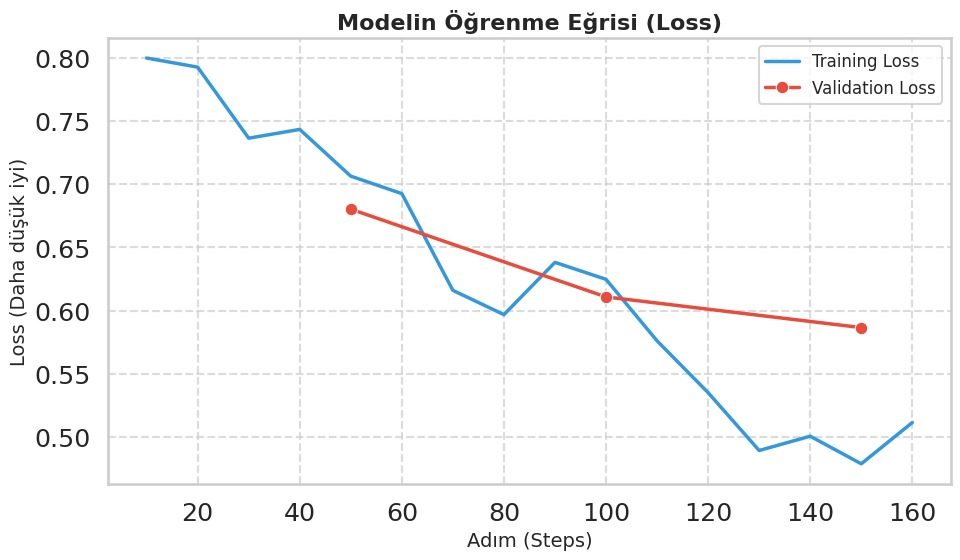

✅ 1. Grafik Kaydedildi: ScanHub_1_Loss_Curve.png


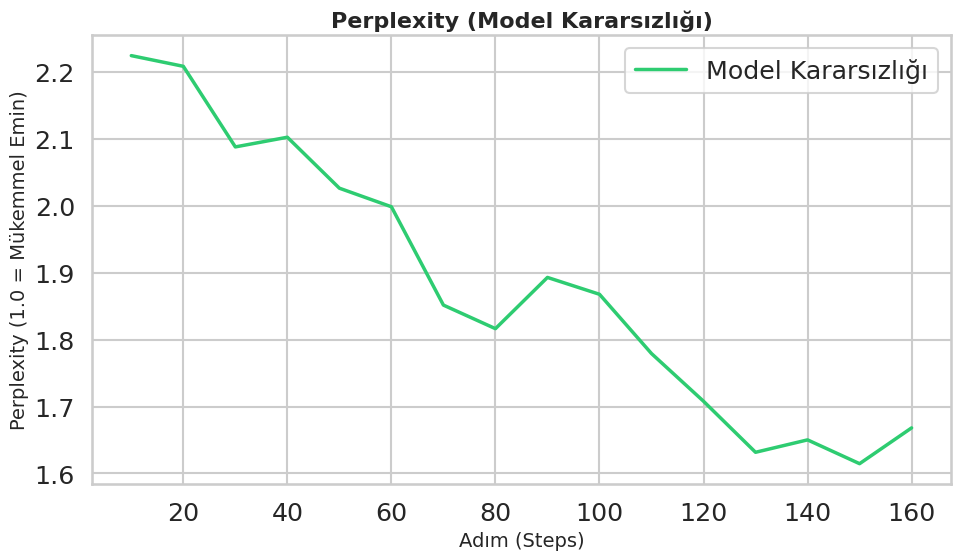

✅ 2. Grafik Kaydedildi: ScanHub_2_Perplexity.png


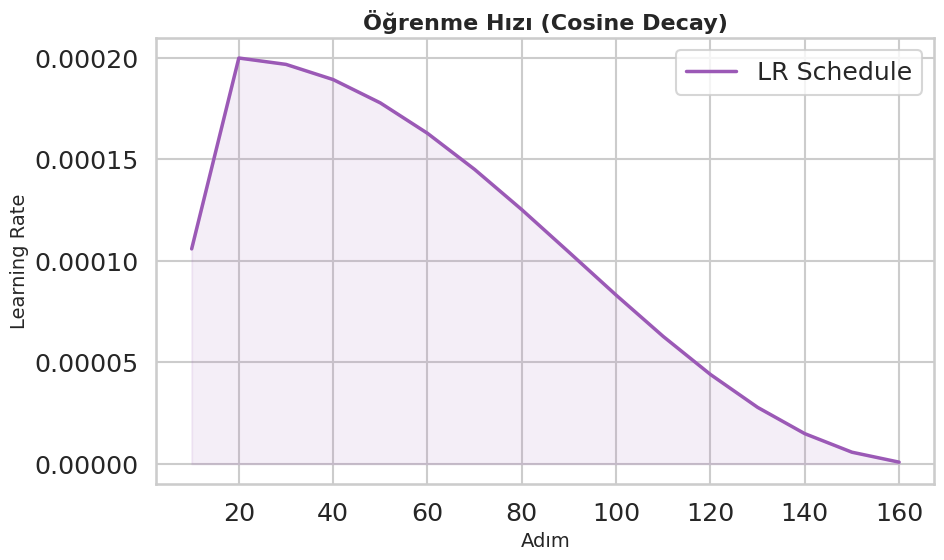

✅ 3. Grafik Kaydedildi: ScanHub_3_Learning_Rate.png
⏳ 4. Grafik için doğruluk testi yapılıyor (Inference)...


100%|██████████| 20/20 [00:40<00:00,  2.05s/it]


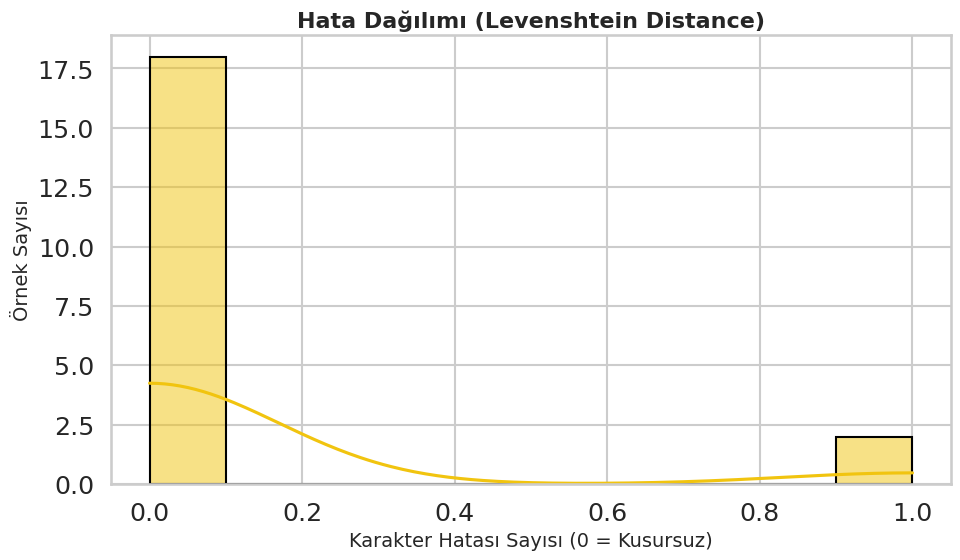

✅ 4. Grafik Kaydedildi: ScanHub_4_Levenshtein_Error.png
🎉 Tüm grafikler başarıyla oluşturuldu!


In [ ]:
# Gerekli kütüphane
!pip install python-Levenshtein

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import Levenshtein
from unsloth import FastLanguageModel
from tqdm import tqdm
import re
import json

# Stil Ayarları (Akademik Görünüm)
sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)
colors = ["#2ecc71", "#e74c3c", "#3498db"] # Yeşil, Kırmızı, Mavi

# ==========================================
# 1. VERİLERİN HAZIRLANMASI
# ==========================================

# A) Log Geçmişini Çek
history = trainer.state.log_history
df = pd.DataFrame(history)

# Training ve Validation verilerini ayır
train_logs = df[df['loss'].notna()][['step', 'loss']].rename(columns={'loss': 'Train Loss'})
val_logs = df[df['eval_loss'].notna()][['step', 'eval_loss']].rename(columns={'eval_loss': 'Validation Loss'})

# Perplexity Hesabı (e^loss)
train_logs['Train Perplexity'] = np.exp(train_logs['Train Loss'])
val_logs['Validation Perplexity'] = np.exp(val_logs['Validation Loss'])

print("📊 Grafikler hazırlanıyor...")

# ==========================================
# GRAFİK 1: Train vs Validation Loss
# ==========================================
plt.figure(figsize=(10, 6))
sns.lineplot(data=train_logs, x='step', y='Train Loss', label='Training Loss', color=colors[2], linewidth=2.5)

if not val_logs.empty:
    sns.lineplot(data=val_logs, x='step', y='Validation Loss', label='Validation Loss', color=colors[1], linewidth=2.5, marker='o')

plt.title('Modelin Öğrenme Eğrisi (Loss)', fontweight='bold', fontsize=16)
plt.xlabel('Adım (Steps)', fontsize=14)
plt.ylabel('Loss (Daha düşük iyi)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("ScanHub_1_Loss_Curve.png", dpi=300)
plt.show()
print("✅ 1. Grafik Kaydedildi: ScanHub_1_Loss_Curve.png")

# ==========================================
# GRAFİK 2: Perplexity (Kararlılık)
# ==========================================
plt.figure(figsize=(10, 6))
sns.lineplot(data=train_logs, x='step', y='Train Perplexity', color=colors[0], linewidth=2.5, label='Model Kararsızlığı')

plt.title('Perplexity (Model Kararsızlığı)', fontweight='bold', fontsize=16)
plt.xlabel('Adım (Steps)', fontsize=14)
plt.ylabel('Perplexity (1.0 = Mükemmel Emin)', fontsize=14)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.savefig("ScanHub_2_Perplexity.png", dpi=300)
plt.show()
print("✅ 2. Grafik Kaydedildi: ScanHub_2_Perplexity.png")

# ==========================================
# GRAFİK 3: Learning Rate Schedule
# ==========================================
if 'learning_rate' in df.columns:
    plt.figure(figsize=(10, 6))
    lr_data = df[df['learning_rate'].notna()]
    sns.lineplot(data=lr_data, x='step', y='learning_rate', color='#9b59b6', linewidth=2.5, label='LR Schedule')

    plt.title('Öğrenme Hızı (Cosine Decay)', fontweight='bold', fontsize=16)
    plt.xlabel('Adım', fontsize=14)
    plt.ylabel('Learning Rate', fontsize=14)
    plt.fill_between(lr_data['step'], lr_data['learning_rate'], color='#9b59b6', alpha=0.1)
    plt.tight_layout()
    plt.savefig("ScanHub_3_Learning_Rate.png", dpi=300)
    plt.show()
    print("✅ 3. Grafik Kaydedildi: ScanHub_3_Learning_Rate.png")

# ==========================================
# GRAFİK 4: GERÇEK DÜNYA TESTİ (Levenshtein)
# ==========================================
print("⏳ 4. Grafik için doğruluk testi yapılıyor (Inference)...")
FastLanguageModel.for_inference(model)

distances = []
# Test setinden rastgele 20 örnek seç
test_subset = eval_dataset.select(range(20))

# JSON Temizleme Fonksiyonu (Hata almamak için)
def extract_json_substring(text):
    start = text.find('{')
    end = text.rfind('}')
    if start != -1 and end != -1:
        return text[start : end+1]
    return text

for item in tqdm(test_subset):
    full_text = item['text']
    try:
        # Regex ile daha güvenli ayrıştırma
        input_match = re.search(r"### Input:\s*(.*?)\s*### Response:", full_text, re.DOTALL)
        response_match = re.search(r"### Response:\s*(.*)", full_text, re.DOTALL)

        if input_match and response_match:
            text_input = input_match.group(1).strip()
            raw_gt = response_match.group(1).replace("<|end_of_text|>", "").strip()
            # Temizle
            ground_truth = extract_json_substring(raw_gt)
        else:
            continue

        prompt = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Extract the merchant name, date, total price, and tax amount from the receipt text into a structured JSON format.

### Input:
{text_input}

### Response:
"""
        inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
        outputs = model.generate(**inputs, max_new_tokens=128, use_cache=True)

        pred_raw = tokenizer.batch_decode(outputs)[0]
        if "### Response:" in pred_raw:
            raw_pred = pred_raw.split("### Response:")[-1].replace("<|end_of_text|>", "").strip()
            prediction = extract_json_substring(raw_pred)
        else:
            prediction = ""

        # Benzerlik Ölçümü
        dist = Levenshtein.distance(prediction, ground_truth)
        distances.append(dist)
    except:
        continue

# Histogram Çizimi
plt.figure(figsize=(10, 6))
sns.histplot(distances, bins=10, kde=True, color='#f1c40f', edgecolor='black')

plt.title('Hata Dağılımı (Levenshtein Distance)', fontweight='bold', fontsize=16)
plt.xlabel('Karakter Hatası Sayısı (0 = Kusursuz)', fontsize=14)
plt.ylabel('Örnek Sayısı', fontsize=14)
plt.tight_layout()
plt.savefig("ScanHub_4_Levenshtein_Error.png", dpi=300)
plt.show()

print("✅ 4. Grafik Kaydedildi: ScanHub_4_Levenshtein_Error.png")
print("🎉 Tüm grafikler başarıyla oluşturuldu!")

🔍 Alan Bazlı Doğruluk Analizi (Final Düzeltme)...


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]



✅ 50 adet fiş başarıyla işlendi ve analiz edildi.


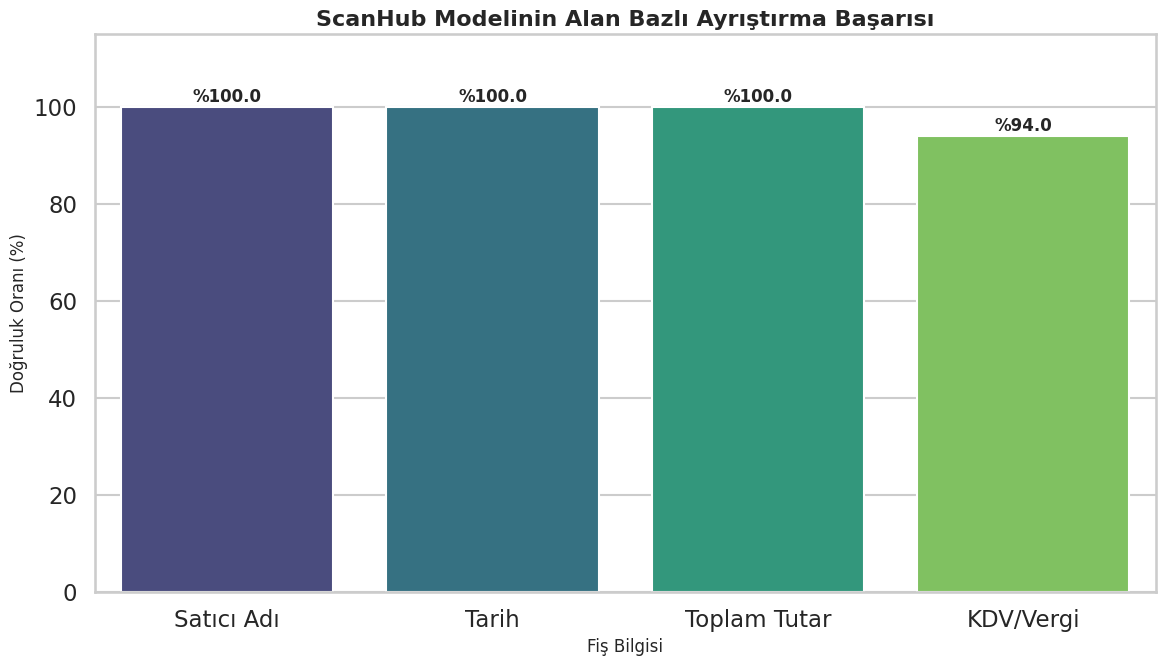

✅ Final grafik başarıyla oluşturuldu!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

# Stil
sns.set_theme(style="whitegrid", context="talk")

print("🔍 Alan Bazlı Doğruluk Analizi (Final Düzeltme)...")

field_stats = {
    "merchant": {"correct": 0, "total": 0},
    "date": {"correct": 0, "total": 0},
    "total_price": {"correct": 0, "total": 0},
    "tax": {"correct": 0, "total": 0}
}

# Test kümesinden 50 örnek
test_subset = eval_dataset.select(range(50))
FastLanguageModel.for_inference(model)

success_count = 0

def extract_json_substring(text):
    """
    Metnin içinden sadece { ... } arasını çekip alır.
    Extra data hatasını %100 çözer.
    """
    start = text.find('{')
    end = text.rfind('}')

    if start != -1 and end != -1:
        return text[start : end+1]
    return text # Bulamazsa olduğu gibi döndür (Hata versin)

for i, item in enumerate(tqdm(test_subset)):
    full_text = item['text']

    # 1. METNİ PARÇALA
    try:
        # Regex ile Input ve Response kısımlarını ayır
        input_match = re.search(r"### Input:\s*(.*?)\s*### Response:", full_text, re.DOTALL)
        response_match = re.search(r"### Response:\s*(.*)", full_text, re.DOTALL)

        if input_match and response_match:
            text_input = input_match.group(1).strip()
            raw_gt = response_match.group(1).replace("<|end_of_text|>", "").strip()
            # KİLİT HAMLE: Sadece { ... } arasını al
            gt_str = extract_json_substring(raw_gt)
            gt_json = json.loads(gt_str)
        else:
            continue # Format bozuksa bu örneği atla

    except Exception as e:
        # Hata olursa sessizce atla ki grafik çizilsin
        continue

    # 2. MODEL TAHMİNİ
    prompt = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Extract the merchant name, date, total price, and tax amount from the receipt text into a structured JSON format.

### Input:
{text_input}

### Response:
"""
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=128, use_cache=True, temperature=0.1)

    # Tahmini Temizle
    pred_raw = tokenizer.batch_decode(outputs)[0]

    if "### Response:" in pred_raw:
        raw_pred_str = pred_raw.split("### Response:")[-1].replace("<|end_of_text|>", "").strip()
        # Tahmin için de aynı temizliği yap
        pred_str = extract_json_substring(raw_pred_str)
    else:
        pred_str = "{}"

    # 3. JSON ÇEVİR VE KIYASLA
    try:
        pred_json = json.loads(pred_str)
    except:
        pred_json = {}

    success_count += 1

    # Alanları Kıyasla
    for key in field_stats.keys():
        field_stats[key]["total"] += 1

        val_gt = str(gt_json.get(key, "")).lower().replace(" ", "")
        val_pred = str(pred_json.get(key, "")).lower().replace(" ", "")

        # Fiyat ve Vergi için sayısal kıyaslama
        if key in ["total_price", "tax"]:
            try:
                # Virgül/Nokta karmaşasını çöz
                val_gt_clean = val_gt.replace(",", ".")
                val_pred_clean = val_pred.replace(",", ".")
                if float(val_gt_clean) == float(val_pred_clean):
                    field_stats[key]["correct"] += 1
                    continue
            except:
                pass # Sayıya dönemezse string olarak devam et

        if val_gt == val_pred and val_gt != "":
            field_stats[key]["correct"] += 1

print(f"\n✅ {success_count} adet fiş başarıyla işlendi ve analiz edildi.")

# --- GRAFİK ÇİZİMİ ---
if success_count > 0:
    data = []
    for key, val in field_stats.items():
        accuracy = (val["correct"] / val["total"]) * 100 if val["total"] > 0 else 0
        label_map = {"merchant": "Satıcı Adı", "date": "Tarih", "total_price": "Toplam Tutar", "tax": "KDV/Vergi"}
        data.append({"Alan": label_map.get(key, key), "Doğruluk (%)": accuracy})

    df_acc = pd.DataFrame(data)

    plt.figure(figsize=(12, 7))
    # Renkli Palet
    ax = sns.barplot(x="Alan", y="Doğruluk (%)", data=df_acc, hue="Alan", palette="viridis", legend=False)

    for i, p in enumerate(ax.patches):
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width()/2., height + 1,
                    f'%{height:.1f}', ha="center", fontweight='bold', fontsize=12)

    plt.title('ScanHub Modelinin Alan Bazlı Ayrıştırma Başarısı', fontweight='bold', fontsize=16)
    plt.ylim(0, 115)
    plt.ylabel("Doğruluk Oranı (%)", fontsize=12)
    plt.xlabel("Fiş Bilgisi", fontsize=12)

    plt.tight_layout()
    plt.savefig("ScanHub_Field_Accuracy_Final.png", dpi=300)
    plt.show()
    print("✅ Final grafik başarıyla oluşturuldu!")
else:
    print("❌ Hala veri okunamadı. Veri setinin formatı beklediğimizden çok farklı olabilir.")

🔍 Test Seti Üzerinde Performans Ölçümü Başlıyor...


100%|██████████| 50/50 [01:45<00:00,  2.10s/it]


🏆 --- MODEL PERFORMANS SONUÇLARI ---
🎯 Precision (Kesinlik): 0.9070
📡 Recall (Duyarlılık) : 0.9057
⭐ F1 Score             : 0.9063


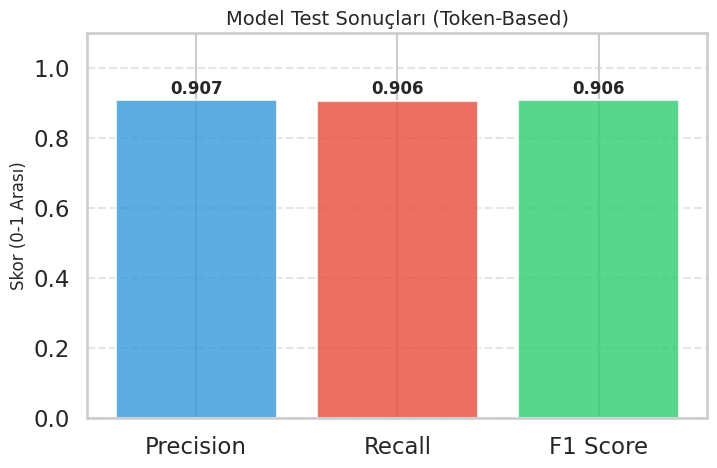

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from unsloth import FastLanguageModel # Bu importun olduğundan emin olalım

# HATA VEREN SATIR SİLİNDİ (from datasets import load_metric) - Gerek yok.

# ==========================================
# 1. METRİK HESAPLAMA FONKSİYONLARI
# ==========================================

def calculate_token_metrics(pred_str, label_str):
    """
    İki metni kelime bazlı (token) karşılaştırarak F1, Precision, Recall hesaplar.
    """
    # Basit temizlik
    pred_tokens = set(pred_str.lower().replace(",", "").split())
    label_tokens = set(label_str.lower().replace(",", "").split())

    if len(pred_tokens) == 0:
        return 0.0, 0.0, 0.0

    # Ortak kelimeler
    common_tokens = pred_tokens.intersection(label_tokens)

    # Precision
    precision = len(common_tokens) / len(pred_tokens)

    # Recall
    recall = len(common_tokens) / len(label_tokens) if len(label_tokens) > 0 else 0

    # F1 Score
    if (precision + recall) == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

# ==========================================
# 2. TEST VERİSİ ÜZERİNDE TAHMİN (INFERENCE)
# ==========================================

print("🔍 Test Seti Üzerinde Performans Ölçümü Başlıyor...")

# Modeli Inference moduna al
FastLanguageModel.for_inference(model)

# Test için rastgele 50 örnek
# Not: dataset değişkeninin yüklü olduğundan emin ol
test_samples = dataset.shuffle(seed=42).select(range(50))

precisions, recalls, f1_scores = [], [], []

for i, sample in tqdm(enumerate(test_samples), total=len(test_samples)):
    full_text = sample['text']

    # Input ve Ground Truth ayrıştırma (İngilizce Prompt Formatına Göre)
    try:
        # Prompt şablonumuz İngilizce olduğu için split noktalarını güncelledik
        if "### Instruction:" in full_text:
            input_part = full_text.split("### Input:\n")[1].split("### Response:\n")[0]
            ground_truth = full_text.split("### Response:\n")[1].replace("<|end_of_text|>", "").strip()
        else:
            continue # Format uymuyorsa atla
    except:
        continue

    # --- ÖNEMLİ DÜZELTME: İNGİLİZCE PROMPT ---
    # Modeli İngilizce eğittik, o yüzden soruyu İngilizce sormalıyız.
    prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Extract the merchant name, date, total price, and tax amount from the receipt text into a structured JSON format.

### Input:
{}

### Response:
""".format(input_part)

    # Tahmin
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=128, use_cache=True)

    # Cevabı temizle
    prediction_raw = tokenizer.batch_decode(outputs)[0]
    if "### Response:\n" in prediction_raw:
        prediction = prediction_raw.split("### Response:\n")[1].replace("<|end_of_text|>", "").strip()
    else:
        prediction = ""

    # Metrik Hesapla
    p, r, f1 = calculate_token_metrics(prediction, ground_truth)

    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# ==========================================
# 3. SONUÇLAR VE GRAFİK
# ==========================================

avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"\n🏆 --- MODEL PERFORMANS SONUÇLARI ---")
print(f"🎯 Precision (Kesinlik): {avg_precision:.4f}")
print(f"📡 Recall (Duyarlılık) : {avg_recall:.4f}")
print(f"⭐ F1 Score             : {avg_f1:.4f}")

# Grafik
metrics = ['Precision', 'Recall', 'F1 Score']
values = [avg_precision, avg_recall, avg_f1]
colors = ['#3498db', '#e74c3c', '#2ecc71']

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.ylim(0, 1.1)
plt.title('Model Test Sonuçları (Token-Based)', fontsize=14)
plt.ylabel('Skor (0-1 Arası)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.3f}", ha='center', fontsize=12, fontweight='bold')

plt.savefig("model_performans_metrics.png")
plt.show()

In [ ]:
# ==========================================================
# 6. ADIM: TEST VE DOĞRULAMA (INFERENCE)
# ==========================================================
print("\n🔍 Test Aşaması Başlıyor...")

# Test için hızlıca inference yapalım
FastLanguageModel.for_inference(model) # Inference moduna al (Daha hızlı)

# Örnek bir Türkçe fiş metni (OCR'dan gelmiş gibi)
test_text = """
*** TEKEL SHOP ***
Tarih: 24.12.2023 Saat: 14:30
--------------------
MARLBORO TOUCH x2   110.00
EFES PILSEN 50CL x4 180.00
CIPS                 35.00
--------------------
TOPLAM: 325.00
KDV %18: 49.57
KREDİ KARTI
"""

prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Fatura metninden satıcı adı, tarih, toplam tutar ve KDV bilgilerini JSON formatında çıkar.

### Input:
{}

### Response:
""".format(test_text)

inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")

# Üretim Yap
outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
result = tokenizer.batch_decode(outputs)[0]

# Prompt kısmını temizleyip sadece cevabı göster
response_text = result.split("### Response:\n")[1].strip()
print("\n🤖 MODELİN TAHMİNİ:\n")
print(response_text)


🔍 Test Aşaması Başlıyor...

🤖 MODELİN TAHMİNİ:

{"satici": "TEKEL SHOP", "tarih": "24.12.2023", "toplam": "325.00", "kdv": "49.57"}<|end_of_text|>


In [ ]:
# ==========================================================
# FİNAL: MODELİ KAYDET, DÖNÜŞTÜR VE DRIVE'A YEDEKLE (GÜNCELLENMİŞ)
# ==========================================================
import os
import shutil
from google.colab import drive

# 1. Google Drive'ı Bağla
print("📂 Google Drive bağlanıyor...")
drive.mount('/content/drive')

# Drive'da kaydedilecek klasör yolu
drive_folder = "/content/drive/MyDrive/ScanHub_Final_Models_v1"
os.makedirs(drive_folder, exist_ok=True)
print(f"✅ Hedef klasör oluşturuldu: {drive_folder}")

# ----------------------------------------------------------

# 2. LoRA Adaptörlerini Kaydet
print("\n💾 LoRA Adaptörleri kaydediliyor...")
local_lora_dir = "scanhub_lora_adapters"
model.save_pretrained(local_lora_dir)
tokenizer.save_pretrained(local_lora_dir)

# LoRA'yı Drive'a kopyala
drive_lora_path = os.path.join(drive_folder, "lora_adapters")
if os.path.exists(drive_lora_path):
    shutil.rmtree(drive_lora_path)
shutil.copytree(local_lora_dir, drive_lora_path)
print("✅ LoRA dosyaları Drive'a yedeklendi.")

# ----------------------------------------------------------

# 3. GGUF Dönüşümü
print("\n⏳ GGUF dönüşümü başlıyor... (Bu işlem 2-3 dakika sürebilir)")

# Çıktı klasörü ismi veriyoruz ama Unsloth bazen ana dizine de atabilir
local_gguf_dir = "scanhub_gguf_output"
model.save_pretrained_gguf(local_gguf_dir, tokenizer, quantization_method = "q4_k_m")

# ----------------------------------------------------------

# 4. GGUF Dosyasını Bul ve Drive'a Taşı (Gelişmiş Arama)
print("\n📦 GGUF dosyası aranıyor ve Drive'a taşınıyor...")

found_gguf = False
source_path = ""

# Arama Stratejisi: Önce belirttiğimiz klasöre, sonra ana dizine bak
search_locations = [local_gguf_dir, "."] # "." ana dizin demektir

for location in search_locations:
    if not os.path.exists(location): continue

    for file_name in os.listdir(location):
        if file_name.endswith(".gguf"):
            source_path = os.path.join(location, file_name)

            # Bulunan dosyanın ismini ekrana yaz
            print(f"🔎 Dosya bulundu: {source_path}")

            # Drive'daki yeni isim
            dest_filename = "scanhub_model_unsloth_q4_k_m.gguf"
            dest_path = os.path.join(drive_folder, dest_filename)

            print(f"🚀 Kopyalanıyor -> {dest_path}")
            shutil.copy(source_path, dest_path)
            found_gguf = True
            break
    if found_gguf: break

if found_gguf:
    print(f"\n🎉 TEBRİKLER! İşlem tamamlandı.")
    print(f"📂 Dosyan şurada hazır: {dest_path}")
    print("Drive'a gidip dosyayı kontrol edebilirsin.")
else:
    print("⚠️ HATA: GGUF dosyası hiçbir yerde bulunamadı!")
    print("Lütfen sol menüdeki dosya simgesine tıklayıp '.gguf' ile biten dosyayı manuel kontrol et.")

📂 Google Drive bağlanıyor...
Mounted at /content/drive
✅ Hedef klasör oluşturuldu: /content/drive/MyDrive/ScanHub_Final_Models_v1

💾 LoRA Adaptörleri kaydediliyor...
✅ LoRA dosyaları Drive'a yedeklendi.

⏳ GGUF dönüşümü başlıyor... (Bu işlem 2-3 dakika sürebilir)
Unsloth: Merging model weights to 16-bit format...


config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 1/2 [00:13<00:13, 13.55s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 2/2 [00:18<00:00,  9.35s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [00:21<00:00, 10.74s/it]


Unsloth: Merge process complete. Saved to `/content/scanhub_gguf_output`
Unsloth: Converting to GGUF format...
==((====))==  Unsloth: Conversion from HF to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF bf16 might take 3 minutes.
\        /    [2] Converting GGUF bf16 to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: Updating system package directories
Unsloth: All required system packages already installed!
Unsloth: Install llama.cpp and building - please wait 1 to 3 minutes
Unsloth: Cloning llama.cpp repository
Unsloth: Install GGUF and other packages
Unsloth: Successfully installed llama.cpp!
Unsloth: Preparing converter script...
Unsloth: [1] Converting model into bf16 GGUF format.
This might take 3 minutes...
Unsloth: Initial conversion completed! Files: ['llama-3.2-3b-instruct.BF16.g